# Импорт библиотек

In [1]:
import pandas as pd
from prophet import Prophet
import pickle as p
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

C:\Users\maxim\anaconda3\envs\py10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Считывание и обработка данных

Перед подачей датафрейма на вход перевел его из .hdf формата в .csv формат и поссчитал среднее значение всех датчиков.

In [2]:
df = pd.read_csv('output.csv')

Формирую датафрейм для предсказания среднего значения по всем датчикам.

In [3]:
d = {'ds': df['TimeStamp'], 'y': df['target']}
rdf = pd.DataFrame(data=d)

In [4]:
rdf.head()

,ds,y
0,2023-08-30,3157.442001
1,2023-08-30,3156.994669
2,2023-08-30,3158.797916
3,2023-08-30,3157.393767
4,2023-08-30,3158.723098


In [5]:
rdf['ds'] = pd.to_datetime(rdf['ds'])

In [6]:
rdf.tail()

,ds,y
123260,2024-10-31,2107.223503
123261,2024-10-31,2107.383913
123262,2024-10-31,2111.521593
123263,2024-10-31,2105.465290
123264,2024-10-31,2166.685843


In [7]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123265 entries, 0 to 123264
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      123265 non-null  datetime64[ns]
 1   y       123265 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [8]:
rdf = rdf.dropna()
rdf

,ds,y
0,2023-08-30,3157.442001
1,2023-08-30,3156.994669
2,2023-08-30,3158.797916
3,2023-08-30,3157.393767
4,2023-08-30,3158.723098
...,...,...
123260,2024-10-31,2107.223503
123261,2024-10-31,2107.383913
123262,2024-10-31,2111.521593
123263,2024-10-31,2105.465290


# Разведочный анализ данных

Строю диаграмму тренда средних значений по датасету, чтобы увидеть тренд для дальнейших предсказаний

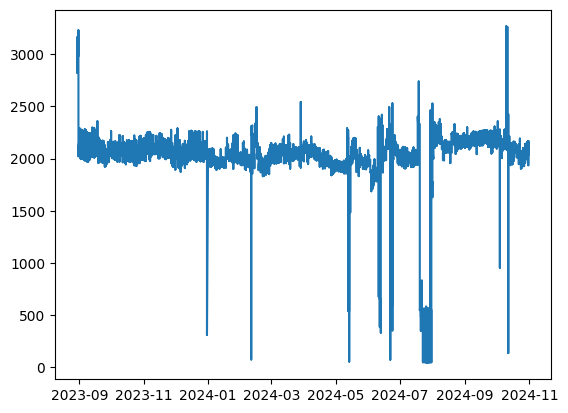

In [9]:
x = np.array(rdf['ds'])
y = np.array(rdf['y'])

plt.plot(x,y)
plt.show()

Следуя из графика среднее значение показателей датчика очень сильно варьируется, а также имеет выбросы показателей.

# Построение и обучение модели

Строю модель

In [11]:
m = Prophet()
m.fit(rdf)

22:06:21 - cmdstanpy - INFO - Chain [1] start processing
22:07:41 - cmdstanpy - INFO - Chain [1] done processing


Сохраняю построеную модель в файл

In [12]:
modelname = 'PredictMidleMeasure.obj'
with open(modelname, 'wb') as handle:
    p.dump(m, handle, protocol=p.HIGHEST_PROTOCOL)

# Использование и валидация модели

Читаю модель из файла

In [14]:
modelname = 'PredictMidleMeasure.obj'

with open(modelname, 'rb') as handle:
    unpickler = p.Unpickler(handle)
    m = unpickler.load()

Использую модель для предсказаний

In [15]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [154]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-08-30,2284.447853,1977.826979,2558.976958,2284.447853,2284.447853,-20.239028,-20.239028,-20.239028,-20.239028,-20.239028,-20.239028,0.0,0.0,0.0,2264.208825
1,2023-08-31,2273.396921,2018.413157,2587.612642,2273.396921,2273.396921,32.028816,32.028816,32.028816,32.028816,32.028816,32.028816,0.0,0.0,0.0,2305.425737
2,2023-09-01,2262.345988,2040.699798,2602.094944,2262.345988,2262.345988,48.228863,48.228863,48.228863,48.228863,48.228863,48.228863,0.0,0.0,0.0,2310.574851
3,2023-09-02,2251.295055,1965.749483,2541.764924,2251.295055,2251.295055,-0.715078,-0.715078,-0.715078,-0.715078,-0.715078,-0.715078,0.0,0.0,0.0,2250.579977
4,2023-09-03,2240.244122,1936.119721,2503.650896,2240.244122,2240.244122,-31.789835,-31.789835,-31.789835,-31.789835,-31.789835,-31.789835,0.0,0.0,0.0,2208.454288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,2025-10-27,1589.477945,-47480.539082,52682.704853,-47629.193730,52751.762912,-2.348181,-2.348181,-2.348181,-2.348181,-2.348181,-2.348181,0.0,0.0,0.0,1587.129765
790,2025-10-28,1588.012706,-47877.143926,53162.718603,-47807.977346,53078.214931,-25.165558,-25.165558,-25.165558,-25.165558,-25.165558,-25.165558,0.0,0.0,0.0,1562.847148
791,2025-10-29,1586.547466,-47960.622314,53000.722130,-48084.483404,53302.204988,-20.239028,-20.239028,-20.239028,-20.239028,-20.239028,-20.239028,0.0,0.0,0.0,1566.308437
792,2025-10-30,1585.082226,-48640.077401,53538.148779,-48360.989462,53508.446281,32.028816,32.028816,32.028816,32.028816,32.028816,32.028816,0.0,0.0,0.0,1617.111042


Строю график предсказаний модели

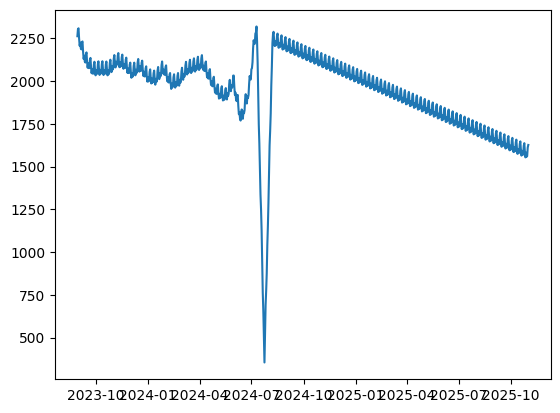

In [19]:
x = np.array(forecast['ds'])
y = np.array(forecast['yhat'])

plt.plot(x,y)
plt.show()

Следуя из показателей модели присутствует тренд на убывание значений.

Создаю метрик датафрейм для измерений метрик

In [24]:
metric_df = forecast.set_index('ds')[['yhat']].join(rdf.set_index('ds')['y']).reset_index()

In [25]:
metric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123630 entries, 0 to 123629
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      123630 non-null  datetime64[ns]
 1   yhat    123630 non-null  float64       
 2   y       123265 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.8 MB


In [26]:
metric_df.tail()

,ds,yhat,y
123625,2025-10-27,1582.293158,NaN
123626,2025-10-28,1558.018558,NaN
123627,2025-10-29,1561.499349,NaN
123628,2025-10-30,1612.179037,NaN
123629,2025-10-31,1627.045647,NaN


Дропаю невалидные y

In [30]:
metric_df.dropna(inplace=True)

In [31]:
metric_df

,ds,yhat,y
0,2023-08-30,2263.033738,3157.442001
1,2023-08-30,2263.033738,3156.994669
2,2023-08-30,2263.033738,3158.797916
3,2023-08-30,2263.033738,3157.393767
4,2023-08-30,2263.033738,3158.723098
...,...,...,...
123260,2024-10-31,2149.908769,2107.223503
123261,2024-10-31,2149.908769,2107.383913
123262,2024-10-31,2149.908769,2111.521593
123263,2024-10-31,2149.908769,2105.465290


MSE

In [33]:
mean_squared_error(metric_df.y, metric_df.yhat)

51034.98907596219

R^2

In [162]:
r2_score(metric_df.y, metric_df.yhat)

0.5583817159587501

MAE

In [35]:
mean_absolute_error(metric_df.y, metric_df.yhat)

104.49022784140205

Следуя из средних показателей модели, есть что можно было улучшить.